# 2023 Immune dataset H3K4me1

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [50]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

In [51]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


## Load peaks

In [52]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')

IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me1']

! mkdir -p {PATH}/pics

In [53]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr

In [54]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,fdr,peaks,avlength,tool
1,/home/jetbrains/data/2023_Immune/sicer/Monocyt...,H3K4me1,Monocyte,0.01,70197,3047.255623,SICER
2,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K4me1,BCell,0.05,141414,878.091823,MACS2
2,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K4me1,BCell,0.05,89375,1864.617611,SPAN
1,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K4me1,Monocyte,0.05,124907,969.924007,MACS2
2,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me1,TCell,0.1,145437,888.263234,MACS2 broad


In [55]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

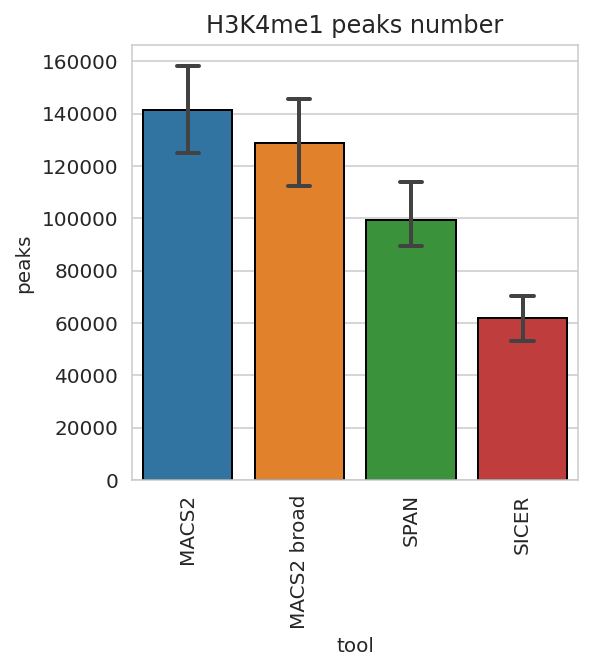

In [56]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=TOOLS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me1 peaks number')
plt.show()

In [57]:
print('Load lengths')
ts = []
for cell, file, tool in tqdm(zip(df_fdr_peaks['cell'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,cell,name
88480,5199,TCell,SICER
74502,1799,Monocyte,SICER
70417,1199,Monocyte,SICER
98762,156,Monocyte,SPAN
119748,376,BCell,SPAN
35166,1294,BCell,MACS2 broad
21544,217,BCell,MACS2
44822,367,Monocyte,MACS2 broad
76700,4399,Monocyte,SICER
29485,877,BCell,MACS2


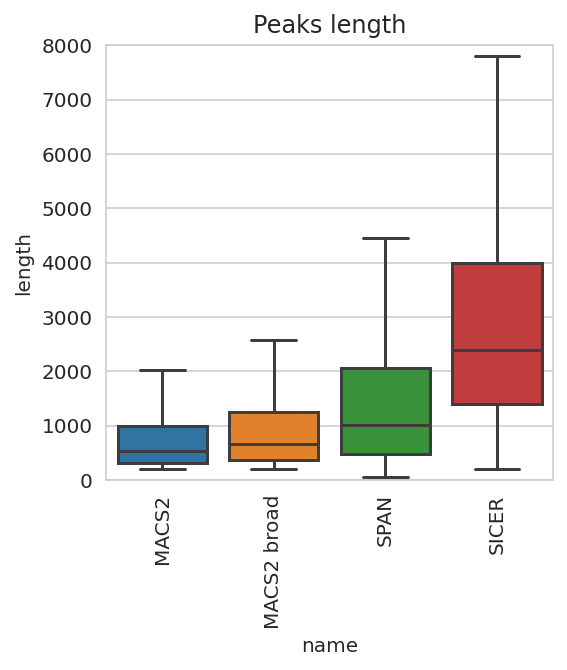

In [58]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False)
ax.title.set_text('Peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 8_000])
plt.show()

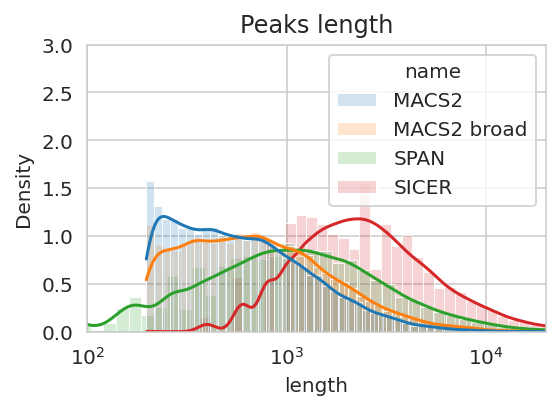

In [59]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=TOOLS)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

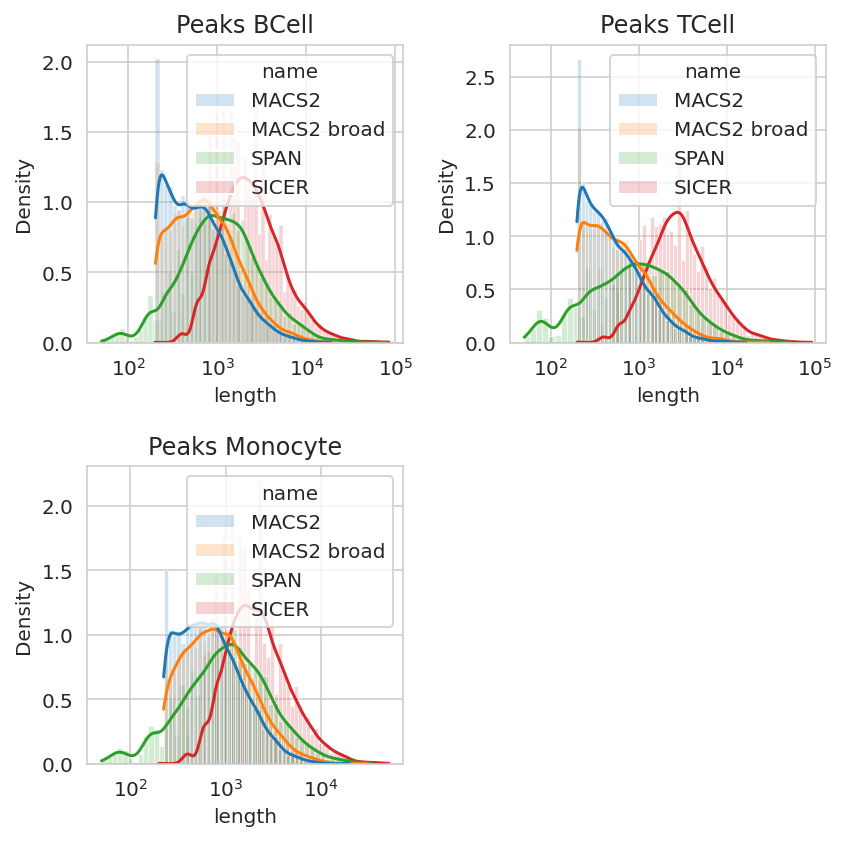

In [60]:
import math
experiments = [c for c in IMMUNE_CELLS if sum(t['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.histplot(data=t[t['cell'] == c],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [61]:
# # Randomly tweak SPAN, SICER lengths for visualization purposes
# tsicer = t['name'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))
# tspan = t['name'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))

In [62]:
# plt.figure(figsize=(8, 5))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          bins=200, kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
# ax.title.set_text('H3K4me1 peaks length')
# plt.show()

In [63]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(10)

0it [00:00, ?it/s]

,tool,coverage
10,SPAN,166428319
11,SPAN,166650199
5,MACS2 broad,129186340
0,MACS2,112015401
2,MACS2,124174477
9,SPAN,196150014
4,MACS2 broad,133706745
8,SICER,219629344
1,MACS2,121150298
7,SICER,213908203


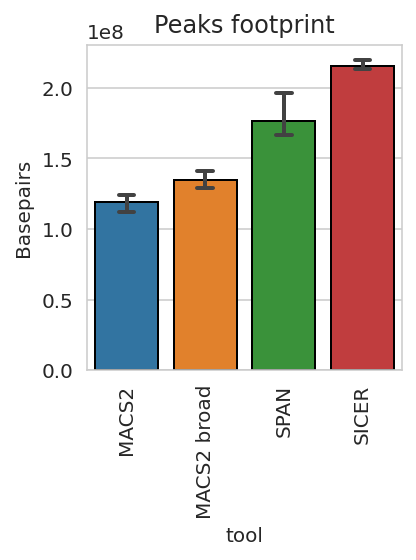

In [64]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between narrow and broad peaks

In [65]:
! mkdir -p {PATH}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'], dtype=object)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'length', 'tool', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K4me1') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{PATH}/union/H3K4me1_{c}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(name=['SPAN'] * len(peak_lengths), peak_lengths=peak_lengths))
            tl['cell'] = c
            tl['length'] = percentage_name
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(name=[tool] * len(peak_lengths), peak_lengths=peak_lengths))
                tl['cell'] = c
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

                # print(tool)
                # ! wc -l {file}-perc
                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e)

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,length,tool,overlap_span_peaks,overlap_tool_peaks
27,TCell,80%-100%,MACS2,27501,84524
6,BCell,40%-60%,MACS2,15180,20973
10,BCell,60%-80%,MACS2 broad,18269,25848


,name,peak_lengths,cell,length
397777,SPAN,483,Monocyte,20%-40%
353732,MACS2,791,TCell,80%-100%
364978,SICER,6399,TCell,80%-100%


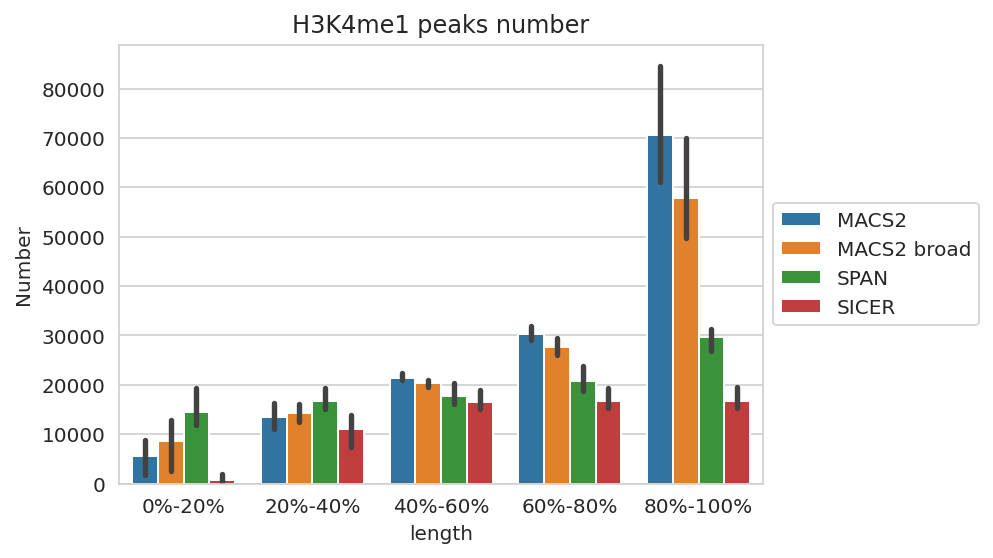

In [66]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
# This can be done faster
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K4me1 peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


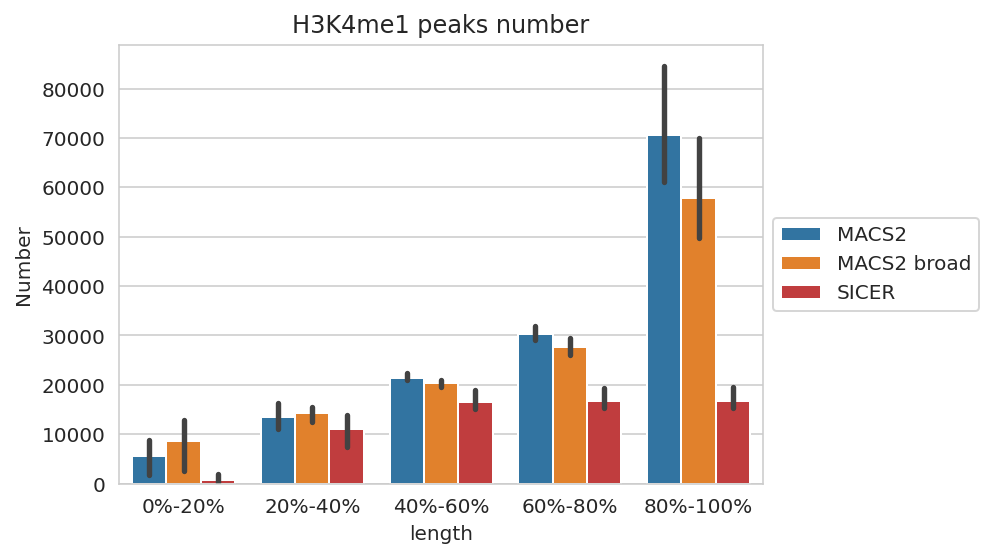

In [67]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
# This can be done faster
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K4me1 peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peaks_percentile_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()


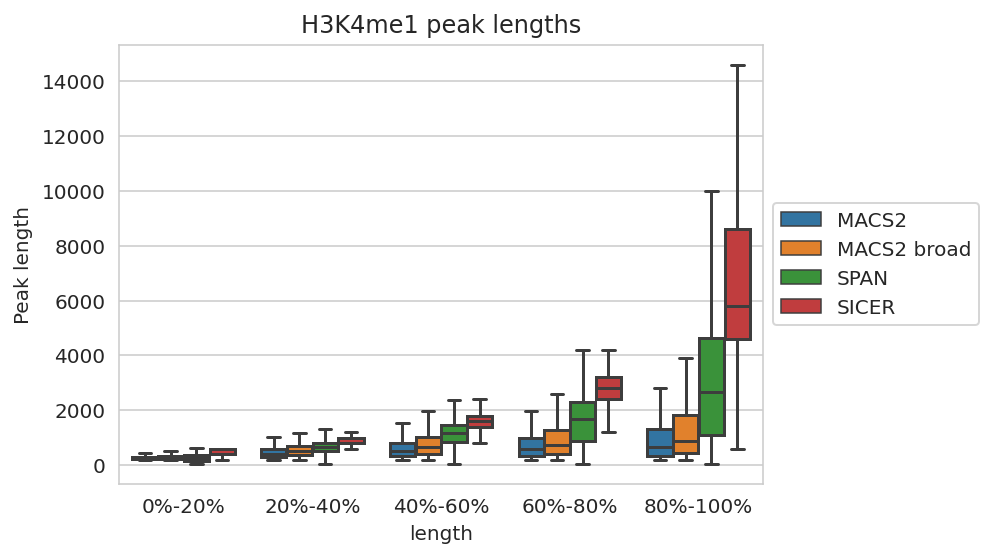

In [21]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me1 peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


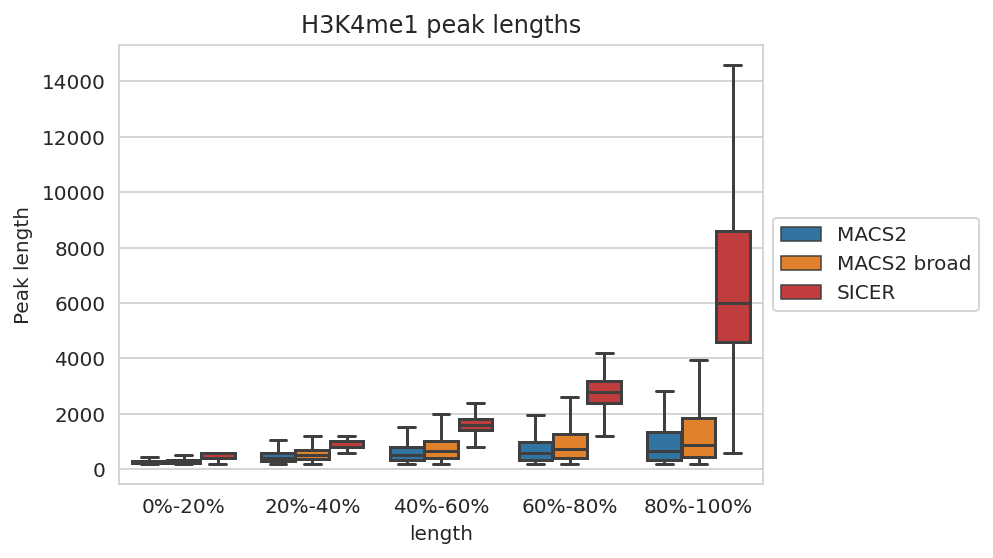

In [68]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me1 peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peak_length_percentile_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()


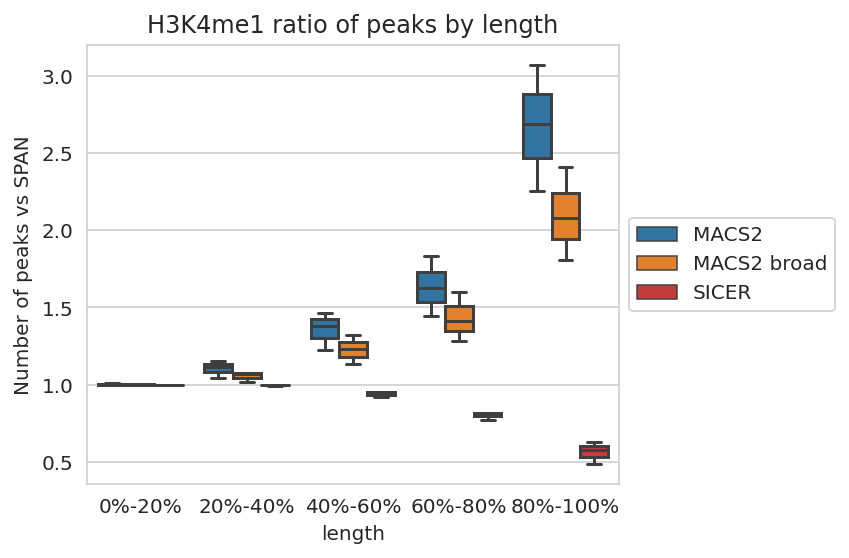

In [22]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me1 ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Difference

In [36]:
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    for tool in df_fdr_peaks['tool'].unique():
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        bench_df.loc[len(bench_df)] = (c, tool, peaks)

  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K4me1') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in df_fdr_peaks['tool'].unique():
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !echo '' > {tf}
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (c, name, peaks)
diff_bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,name,peaks
0,BCell,SPAN - MACS2,10037
1,BCell,MACS2 - SPAN,1387
2,BCell,SPAN - MACS2 broad,5335
3,BCell,MACS2 broad - SPAN,4042
4,BCell,SPAN - SICER,11688
5,BCell,SICER - SPAN,138
6,TCell,SPAN - MACS2,17524
7,TCell,MACS2 - SPAN,1210
8,TCell,SPAN - MACS2 broad,11230
9,TCell,MACS2 broad - SPAN,4420


In [38]:
full_diff_bench_df = pd.concat([bench_df[['cell', 'name', 'peaks']],
                                diff_bench_df[['cell', 'name', 'peaks']]]).reset_index(drop=True)
full_diff_bench_df

,cell,name,peaks
0,BCell,MACS2,141414
1,BCell,MACS2 broad,127965
2,BCell,SICER,62076
3,BCell,SPAN,89375
4,TCell,MACS2,158205
5,TCell,MACS2 broad,145437
6,TCell,SICER,53056
7,TCell,SPAN,94649
8,Monocyte,MACS2,124907
9,Monocyte,MACS2 broad,112393


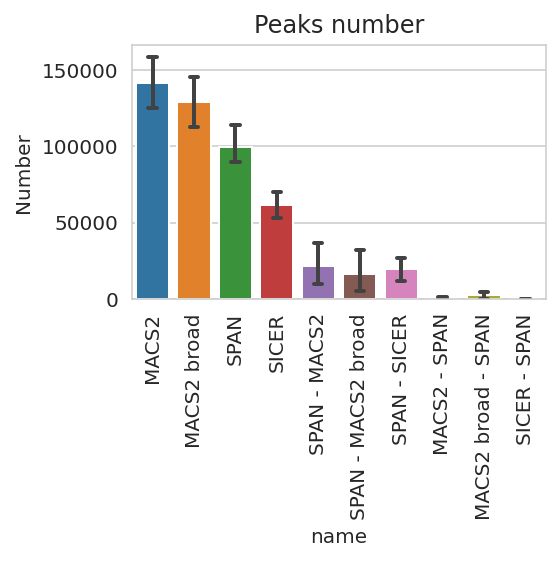

In [39]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
# ax.set_ylim(top=1e5)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

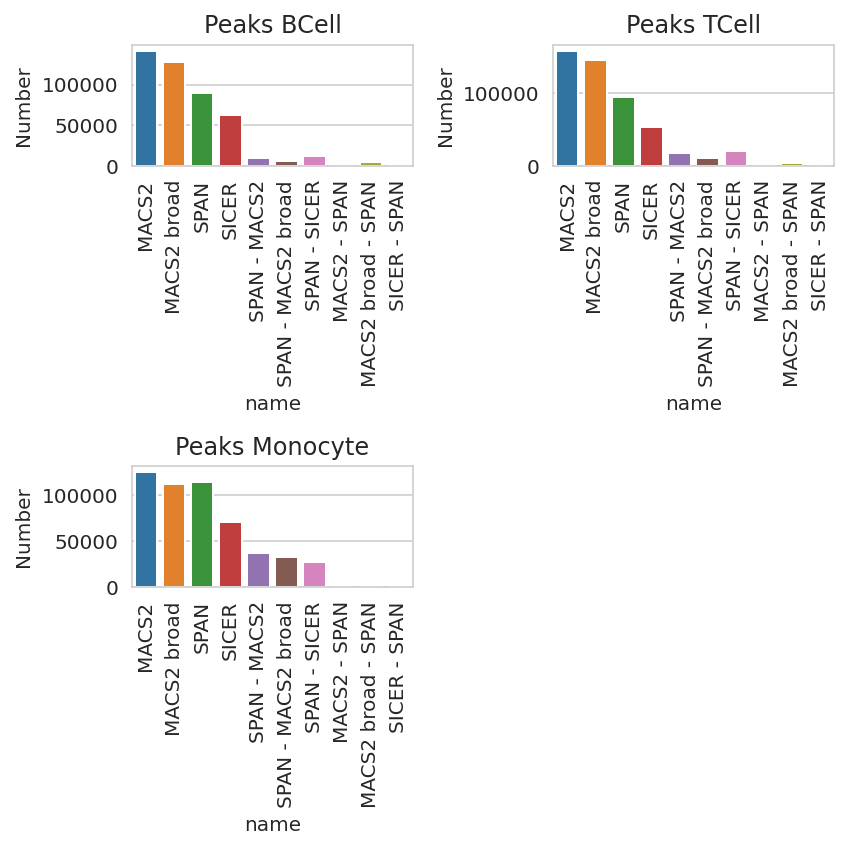

In [41]:
import math
experiments = [c for c in IMMUNE_CELLS
               if sum(full_diff_bench_df['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['cell'] == c],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save benchmark

In [19]:
full_diff_bench_df.to_csv(PATH + '/H3K4me1_full_bench_df.csv.gz', index=False, compression='gzip')

# Functional annotation

In [20]:
import tempfile

tf = tempfile.mktemp()

! rm -r {PATH}/summary_H3K4me1
! mkdir -p {PATH}/summary_H3K4me1

TOOLS = list(sorted(set(bench_df['name'])))

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{PATH}/summary_H3K4me1/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            !cat {tf} >> "{PATH}/summary_H3K4me1/{filename}.bed_"

for f in os.listdir(PATH + '/summary_H3K4me1'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{PATH}/summary_H3K4me1/{f}" | cut -f1-3 > "{PATH}/summary_H3K4me1/{f_sorted}"
    ! rm "{PATH}/summary_H3K4me1/{f}"

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


# Coverage

In [7]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = PATH + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [8]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K4me1')
display(bws_df.sample(3))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(3))

  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
1,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,H3K4me1,Monocyte
2,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,H3K4me1,BCell
0,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,H3K4me1,TCell


  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
0,/home/jetbrains/data/2023_Immune/bw/TCell_Cont...,Control,TCell
2,/home/jetbrains/data/2023_Immune/bw/BCell_Cont...,Control,BCell
1,/home/jetbrains/data/2023_Immune/bw/Monocyte_C...,Control,Monocyte


In [9]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

# FRIP

In [10]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K4me1') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(
                bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)
frip_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
SICER /tmp/tmpswjt58q5 /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me1_hg38_ENCFF584OXC.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 /tmp/tmpz55gzyj9 /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me1_hg38_ENCFF584OXC.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 broad /tmp/tmpcnlx8bv7 /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me1_hg38_ENCFF584OXC.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SPAN /tmp/tmpe1gl6lwd /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me1_hg38_ENCFF584OXC.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
TCell
SICER /tmp/tmpyl8qmwdr /home/jetbrains/data/2023_Immune/bw/TCell_H3K4me1_hg38_ENCFF737JXT.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
MACS2 /tmp/tmpg5palvuw /home/jetbrains/data/2023_Immune/bw/TCell_H3K4me1_hg38_ENCFF737JXT.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
MACS2

,cell,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,SICER,/tmp/tmpswjt58q5,62076,213196724,5.350549e+07,8.492616e+07,7.824874e+06,8.481521e+07
1,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,MACS2,/tmp/tmpz55gzyj9,141414,124174477,4.639265e+07,8.492616e+07,4.405099e+06,8.483739e+07
2,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,MACS2 broad,/tmp/tmpcnlx8bv7,127965,141202454,4.849406e+07,8.492616e+07,5.023498e+06,8.483739e+07
3,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,SPAN,/tmp/tmpe1gl6lwd,89375,166650199,5.053932e+07,8.493336e+07,6.107937e+06,8.491783e+07
4,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,SICER,/tmp/tmpyl8qmwdr,53056,219629344,5.509794e+07,8.492514e+07,7.604401e+06,8.482415e+07
5,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,MACS2,/tmp/tmpg5palvuw,158205,112015401,4.671643e+07,8.492514e+07,3.739993e+06,8.486283e+07
6,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,MACS2 broad,/tmp/tmpbif81qqc,145437,129186340,4.896578e+07,8.492514e+07,4.312154e+06,8.486283e+07
7,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,SPAN,/tmp/tmpgcpc7_uz,94649,166428319,5.192860e+07,8.492514e+07,5.794472e+06,8.488192e+07
8,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,SICER,/tmp/tmp34iywi4x,70197,213908203,6.503760e+07,8.495646e+07,8.843766e+06,8.478965e+07
9,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,MACS2,/tmp/tmp0nfixao0,124907,121150298,5.595059e+07,8.495646e+07,5.089113e+06,8.481075e+07


In [11]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

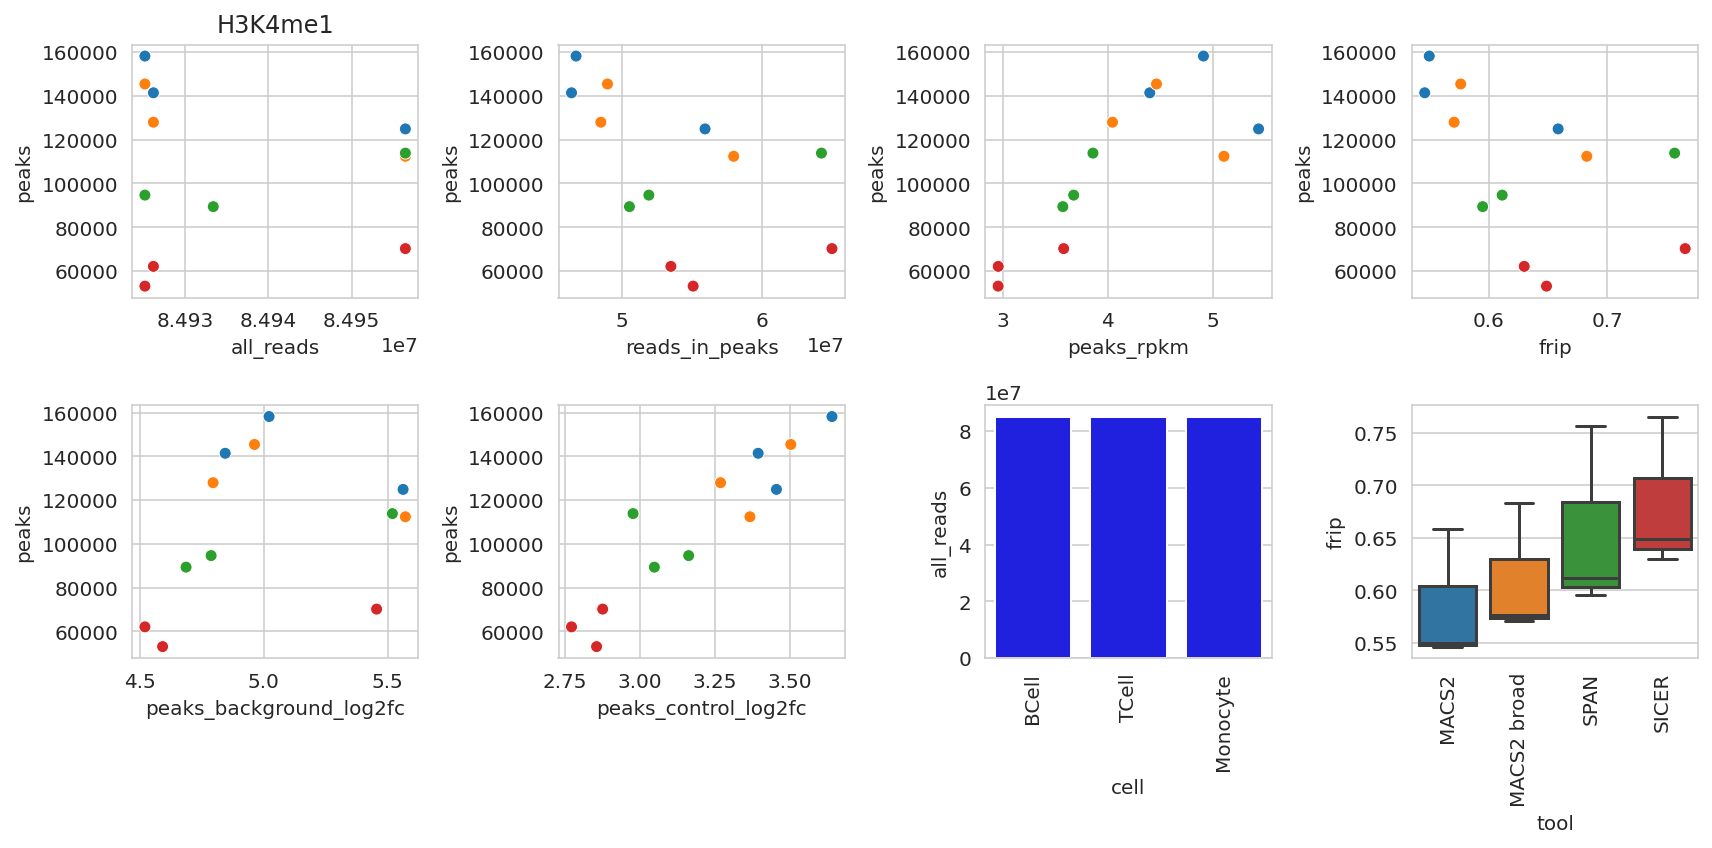

In [12]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K4me1')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{PATH}/pics/H3K4me1_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
frip_df.to_csv(f'{PATH}/pics/H3K4me1_frip.csv.gz', index=None, compression='gzip')

## Peaks Density

In [14]:
import pyBigWig
import tempfile

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K4me1') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me1', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me1', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me1', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me1', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,modification,cell,name,position,length,type,coverage,total_coverage
467838,H3K4me1,BCell,SPAN,chrX:54819116-54819793,677,treatment,123.839085,8.493336e+07
140300,H3K4me1,BCell,MACS2 broad,chr10:93495217-93496003,786,treatment,211.894021,8.492616e+07
419246,H3K4me1,BCell,SPAN,chr19:6720530-6725673,5143,treatment,1783.970147,8.493336e+07
2744719,H3K4me1,Monocyte,MACS2,chr7:157507962-157508653,691,control,220.603012,8.481075e+07
1340906,H3K4me1,TCell,SPAN,chr17:47071303-47072290,987,treatment,234.094172,8.492514e+07


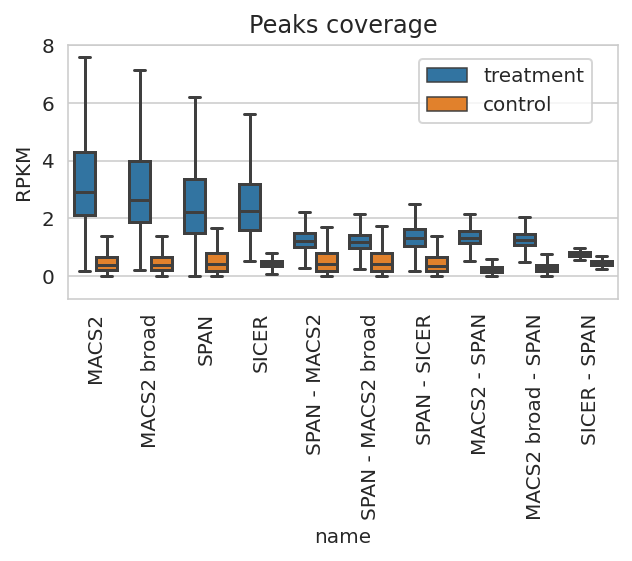

In [15]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-0.8, 8)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [16]:
CHROMHMM_MAP = {
    'BCell': PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [30]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,BCell,MACS2 broad,127965,17775,6164,13018,6209,1828,53338,4586,...,21249,13675,5344,4659,26126,13450,17515,35905,32013,0
1,BCell,MACS2,141414,20863,7047,14311,6789,2034,60502,4254,...,20235,12910,4361,5075,27438,13862,18267,34373,30796,0
2,BCell,SICER,62076,12782,4524,9120,4511,1490,33124,3731,...,16592,11674,8143,3661,18235,11004,12902,24560,22474,0
3,BCell,SPAN,89375,14179,4752,10717,4849,1585,40217,3997,...,17592,11747,5472,4020,22444,12355,15410,27456,24520,0
4,BCell,SPAN - MACS2,10037,31,63,196,192,1,1076,536,...,1283,1021,73,9,172,55,80,2663,2150,0
5,BCell,MACS2 - SPAN,1387,2,1,72,19,0,126,77,...,359,243,6,3,14,3,6,267,188,0
6,BCell,SPAN - MACS2 broad,5335,22,41,85,87,0,498,250,...,615,499,38,5,86,18,42,1447,1181,0
7,BCell,MACS2 broad - SPAN,4042,4,6,160,57,0,361,224,...,921,647,13,4,30,6,11,860,619,0
8,BCell,SPAN - SICER,11688,17,34,652,107,1,1071,700,...,2717,1986,24,21,149,56,46,1819,1353,0
9,BCell,SICER - SPAN,138,0,1,0,13,0,18,11,...,5,4,0,0,2,0,1,68,59,0


In [31]:
chrommm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
chrommm_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,26350.333333,5524.000000,14006.666667,6920.333333,2824.333333,60495.333333,1852.666667,33506.333333,19595.333333,11784.666667,4930.666667,6096.333333,27726.000000,10657.333333,21113.333333,36650.000000,32055.666667,0.0
MACS2 broad,22698.000000,5184.000000,12769.000000,6256.666667,2463.666667,53453.666667,2049.000000,35937.333333,20834.000000,12854.000000,5917.333333,5628.333333,26247.666667,10351.333333,20095.333333,38427.333333,33322.666667,0.0
SPAN,17372.333333,4636.666667,10957.666667,5056.666667,1928.000000,40992.333333,2079.666667,38809.000000,19093.333333,12028.666667,7086.666667,4861.000000,21760.000000,9549.000000,16909.333333,33693.000000,29491.666667,0.0
SICER,15342.000000,4583.666667,9289.333333,4523.333333,1760.333333,34069.000000,1861.666667,28319.333333,16042.666667,11114.333333,8602.666667,4379.666667,17678.000000,8724.333333,13957.333333,26511.666667,24364.000000,0.0
SPAN - MACS2,327.000000,277.333333,553.000000,259.333333,29.000000,1752.666667,447.000000,10812.666667,2800.000000,1850.333333,216.666667,65.666667,428.666667,120.666667,252.333333,5771.333333,4395.333333,0.0
SPAN - MACS2 broad,234.333333,207.666667,417.333333,170.000000,20.666667,1169.333333,300.333333,8514.666667,1963.666667,1254.000000,155.666667,49.666667,287.333333,72.333333,165.333333,4274.333333,3274.000000,0.0
SPAN - SICER,199.333333,185.666667,707.666667,149.000000,14.666667,1283.333333,482.666667,9759.333333,3811.666667,2512.000000,72.666667,59.666667,285.666667,95.666667,115.666667,3902.000000,2851.333333,0.0
MACS2 - SPAN,2.333333,2.333333,34.333333,7.333333,0.000000,47.333333,30.000000,296.000000,252.666667,152.666667,3.333333,1.000000,9.333333,2.000000,4.000000,195.666667,131.333333,0.0
MACS2 broad - SPAN,9.666667,12.000000,74.333333,23.666667,0.000000,146.666667,96.000000,998.000000,743.333333,491.333333,9.333333,2.333333,23.000000,5.000000,10.333333,755.333333,495.333333,0.0


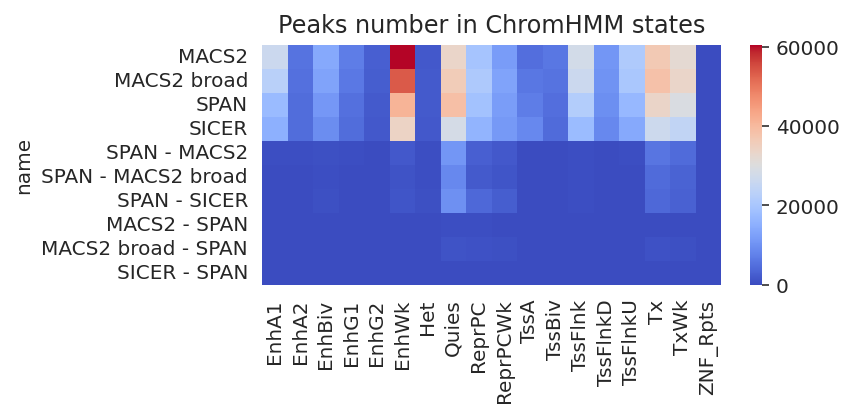

In [32]:
plt.figure(figsize=(6, 3))
sns.heatmap(chrommm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [33]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,0.187151,0.039138,0.098109,0.048193,0.019590,0.433369,0.013117,0.244402,0.134026,0.080590,0.034464,0.043243,0.196574,0.074598,0.150470,0.260588,0.229244,0.0
MACS2 broad,0.177876,0.040398,0.098685,0.048104,0.018885,0.422575,0.015993,0.288103,0.156482,0.096290,0.045590,0.044083,0.205398,0.079866,0.158094,0.299744,0.261735,0.0
SPAN,0.174642,0.047304,0.112295,0.051670,0.019607,0.413266,0.022017,0.381935,0.197184,0.125054,0.071054,0.049141,0.221407,0.099550,0.170571,0.337684,0.294766,0.0
SICER,0.249906,0.075570,0.155243,0.074573,0.029128,0.549880,0.030218,0.448135,0.270766,0.189348,0.140215,0.072374,0.289084,0.144977,0.227696,0.428506,0.393037,0.0
SPAN - MACS2,0.013822,0.011947,0.021217,0.014087,0.001293,0.086724,0.027617,0.470168,0.139406,0.099479,0.009726,0.002281,0.019980,0.005884,0.011663,0.286440,0.214592,0.0
SPAN - MACS2 broad,0.013743,0.012108,0.018580,0.012446,0.001241,0.077235,0.025417,0.474126,0.129334,0.093174,0.009331,0.002133,0.018321,0.004578,0.010690,0.289515,0.216389,0.0
SPAN - SICER,0.009111,0.008550,0.039280,0.008046,0.000674,0.070545,0.030564,0.479329,0.211472,0.143134,0.003469,0.002896,0.014791,0.005121,0.005835,0.197114,0.142907,0.0
MACS2 - SPAN,0.001858,0.001893,0.025843,0.005393,0.000000,0.034689,0.022086,0.227367,0.196195,0.117628,0.002544,0.000721,0.007221,0.001547,0.003095,0.152322,0.101931,0.0
MACS2 broad - SPAN,0.002215,0.002757,0.017946,0.005756,0.000000,0.035729,0.023299,0.237027,0.174670,0.115724,0.002203,0.000556,0.005415,0.001174,0.002415,0.176955,0.116432,0.0


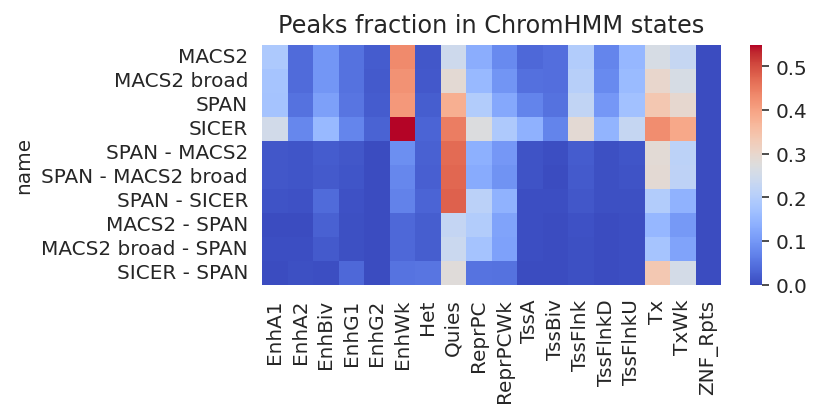

In [34]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me1_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()